# Ball simulation

This part is dedicated to create the simulation of the ball dynamics, depending of the plateau angle.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT, FILTERING_PERIOD
print(DT)

0.02


# Simulation

p_t+1 = p_t + s_t * dt

p = [x, y]

s = [d_x, d_y]

## Data preparation

In this part, the recorded data are loaded and prepared. The goal is to train the neural network on those datas.

In [3]:
data_file_names = os.listdir('src/data/train')
test_data_file_names = os.listdir('src/data/test')

In [4]:
datas = [pd.read_csv('src/data/train/{}'.format(file_name)) for file_name in data_file_names if 'ball' in file_name]
test_datas = [pd.read_csv('src/data/test/{}'.format(file_name)) for file_name in test_data_file_names if 'ball' in file_name]

Data visualisation

<IPython.core.display.Javascript object>


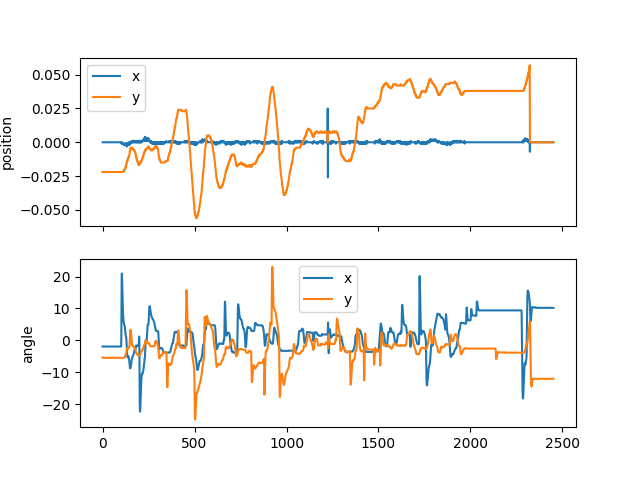

In [5]:
for data in datas[:1]:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'] - data['x'].shift(1), label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

It is possible to see that at some moments, the ball was undetected. Either for a one timestep, either for the whole end.

Regressions are very sensitive to outliers, thus it is very important to remove those errors

In [6]:
for data in datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
for data in test_datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
    
datas[-1] = datas[-1].iloc[:380, :]

<IPython.core.display.Javascript object>


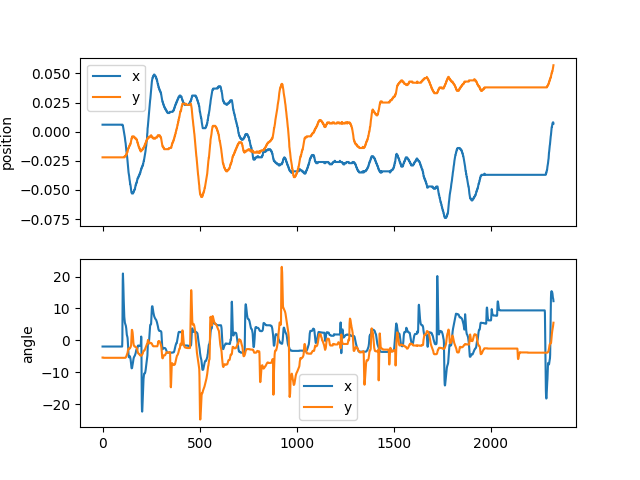

In [7]:
for data in datas[:1]:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

In [8]:
'''for data in test_datas:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()'''

"for data in test_datas:\n    fig, axs = plt.subplots(2, 1, sharex=True)\n\n    axs[0].plot(data['x'], label='x')\n    axs[0].plot(data['y'], label='y')\n    axs[0].set_ylabel('position')\n    axs[0].legend()\n\n    axs[1].plot(data['angle_x'], label='x')\n    axs[1].plot(data['angle_y'], label='y')\n    axs[1].set_ylabel('angle')\n    axs[1].legend()\n\n    plt.show()"

Since all datasets are cleaned. It is now possible to compute the speed and concaten them.

In [9]:
lag: int = 2

for data in datas:
    data['sin_angle_x'] = np.sin(data['angle_x'] * np.pi / 180.)
    data['sin_angle_y'] = np.sin(data['angle_y'] * np.pi / 180.)
    data['smoothed_x'] = data['x'].ewm(span=lag).mean()
    data['smoothed_y'] = data['y'].ewm(span=lag).mean()
    data['d_smoothed_x'] = data['smoothed_x'].ewm(span=lag).mean()
    data['d_smoothed_y'] = data['smoothed_y'].ewm(span=lag).mean()
    data['dema_x'] = (2. * data['d_smoothed_x']) - data['d_smoothed_x']
    data['dema_y'] = (2. * data['d_smoothed_y']) - data['d_smoothed_y']
    data['d_x'] = ((data['dema_x'] - data['dema_x'].shift(1)) / DT).rolling(window=lag).mean().shift(-lag)
    data['d_y'] = ((data['dema_y'] - data['dema_y'].shift(1)) / DT).rolling(window=lag).mean().shift(-lag)
    data['tl'] = np.where((data['x']<0.) & (data['y']>0.), 1., 0.)
    data['br'] = np.where((data['x']>0.) & (data['y']<0.), 1., 0.)
    data['bl'] = np.where((data['x']<0.) & (data['y']<0.), 1., 0.)
    data['tr'] = np.where((data['x']>0.) & (data['y']>0.), 1., 0.)
    data['target_x'] = data['d_x'].shift(-1) - data['d_x']
    data['target_y'] = data['d_y'].shift(-1) - data['d_y']
    data.dropna(inplace=True)
for data in test_datas:
    data['sin_angle_x'] = np.sin(data['angle_x'] * np.pi / 180.)
    data['sin_angle_y'] = np.sin(data['angle_y'] * np.pi / 180.)
    data['smoothed_x'] = data['x'].ewm(span=lag).mean()
    data['smoothed_y'] = data['y'].ewm(span=lag).mean()
    data['d_smoothed_x'] = data['smoothed_x'].ewm(span=lag).mean()
    data['d_smoothed_y'] = data['smoothed_y'].ewm(span=lag).mean()
    data['dema_x'] = (2. * data['d_smoothed_x']) - data['d_smoothed_x']
    data['dema_y'] = (2. * data['d_smoothed_y']) - data['d_smoothed_y']
    data['d_x'] = ((data['dema_x'] - data['dema_x'].shift(1)) / DT).rolling(window=lag).mean().shift(-lag)
    data['d_y'] = ((data['dema_y'] - data['dema_y'].shift(1)) / DT).rolling(window=lag).mean().shift(-lag)
    data['tl'] = np.where((data['x']<0.) & (data['y']>0.), 1., 0.)
    data['br'] = np.where((data['x']>0.) & (data['y']<0.), 1., 0.)
    data['bl'] = np.where((data['x']<0.) & (data['y']<0.), 1., 0.)
    data['tr'] = np.where((data['x']>0.) & (data['y']>0.), 1., 0.)
    data['target_x'] = data['d_x'].shift(-1) - data['d_x']
    data['target_y'] = data['d_y'].shift(-1) - data['d_y']
    data.dropna(inplace=True)
    
data = datas[0]
for df in datas[0:]:
    data = pd.concat([data, df])
data.reset_index(inplace=True, drop=True)
print(data.head())

       x      y  angle_x  angle_y  input_x  input_y  sin_angle_x  sin_angle_y  \
0  0.006 -0.022   -1.929   -5.384   -0.210   -0.173    -0.033661     -0.09383   
1  0.006 -0.022   -1.929   -5.384   -0.229   -0.169    -0.033661     -0.09383   
2  0.006 -0.022   -1.929   -5.384   -0.255   -0.164    -0.033661     -0.09383   
3  0.006 -0.022   -1.929   -5.384   -0.227   -0.176    -0.033661     -0.09383   
4  0.006 -0.022   -1.929   -5.384   -0.191   -0.187    -0.033661     -0.09383   

   smoothed_x  smoothed_y  ...  dema_x  dema_y  d_x  d_y   tl   br   bl   tr  \
0       0.006      -0.022  ...   0.006  -0.022  0.0  0.0  0.0  1.0  0.0  0.0   
1       0.006      -0.022  ...   0.006  -0.022  0.0  0.0  0.0  1.0  0.0  0.0   
2       0.006      -0.022  ...   0.006  -0.022  0.0  0.0  0.0  1.0  0.0  0.0   
3       0.006      -0.022  ...   0.006  -0.022  0.0  0.0  0.0  1.0  0.0  0.0   
4       0.006      -0.022  ...   0.006  -0.022  0.0  0.0  0.0  1.0  0.0  0.0   

   target_x  target_y  
0       

<IPython.core.display.Javascript object>


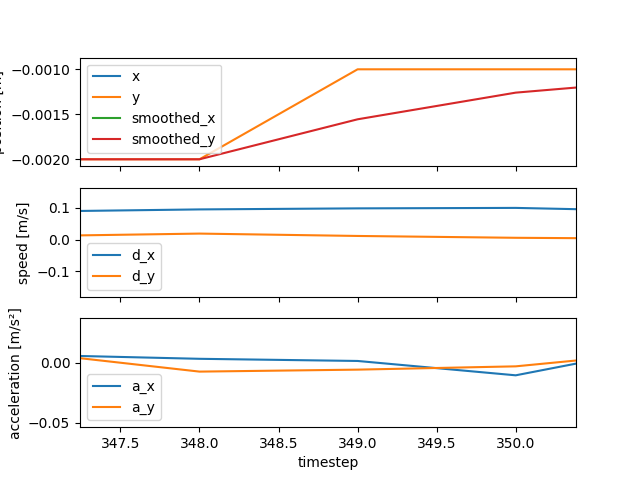

<IPython.core.display.Javascript object>


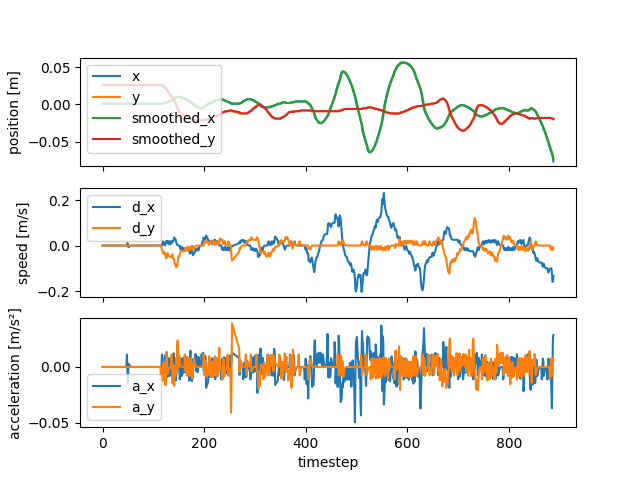

<IPython.core.display.Javascript object>


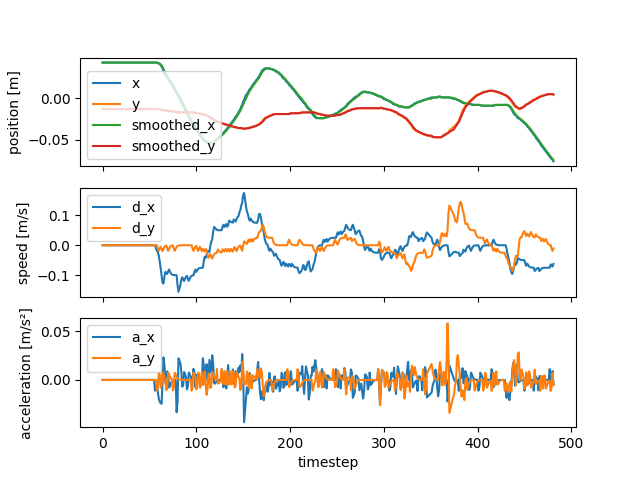

<IPython.core.display.Javascript object>


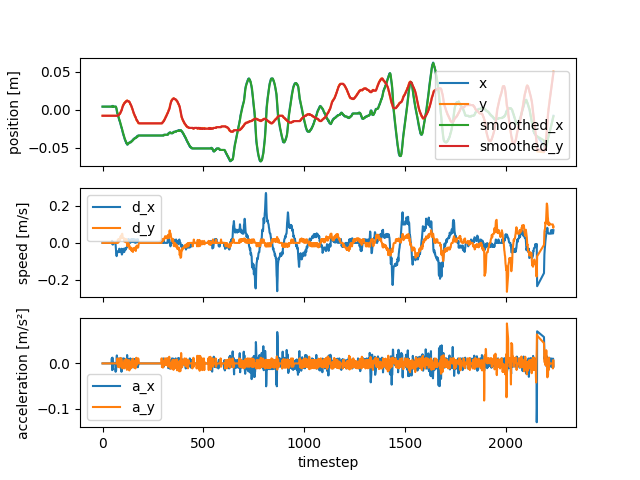

In [10]:
for data in test_datas:
    fig, axs = plt.subplots(3, 1, sharex=True)
    
    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].plot(data['dema_x'], label='smoothed_x')
    axs[0].plot(data['dema_y'], label='smoothed_y')
    axs[0].set_ylabel('position [m]')
    axs[0].legend()

    axs[1].plot(data['d_x'], label='d_x')
    axs[1].plot(data['d_y'], label='d_y')
    axs[1].set_ylabel('speed [m/s]')
    axs[1].legend()

    axs[2].plot(data['target_x'], label='a_x')
    axs[2].plot(data['target_y'], label='a_y')
    axs[2].set_ylabel('acceleration [m/s²]')
    axs[2].set_xlabel('timestep')
    axs[2].legend()

    plt.show()

## Scaling

In [11]:
max(- data['x'].min(), data['x'].max())

0.068

In [84]:
max(- data['y'].min(), data['y'].max())

0.055999999999999994

In [85]:
max(- data['d_x'].min(), data['d_x'].max(), - data['d_y'].min(), data['d_y'].max())

0.2701433538452178

In [86]:
data['d_x'].std()

0.05573470648788174

In [87]:
data['d_x'].abs().mean()

0.03622805596773374

In [88]:
data['sin_angle_x'].abs().mean()

0.09932939297752068

In [89]:
data['sin_angle_x'].std()

0.1359138325363827

In [90]:
data['target_x'].abs().mean()

0.006429993715716393

## Inputs

- d_x
- d_y
- sin_angle_x * 7
- sin_angle_y * 7

## Output
- d_x
- d_y

In [91]:
x_np = data[['tr', 'tl','br', 'bl', 'd_x', 'd_y', 'sin_angle_x', 'sin_angle_y']].to_numpy()

x_np[:, 4] = x_np[:, 4]
x_np[:, 5] = x_np[:, 5]
x_np[:, 6] = x_np[:, 6] * 7.
x_np[:, 7] = x_np[:, 7] * 7.

y_np = data[['target_x', 'target_y']].to_numpy()

x = Variable(
    torch.from_numpy(
        x_np
    ).type(torch.FloatTensor)
)

y = Variable(
    torch.from_numpy(y_np).type(torch.FloatTensor)
)

<IPython.core.display.Javascript object>


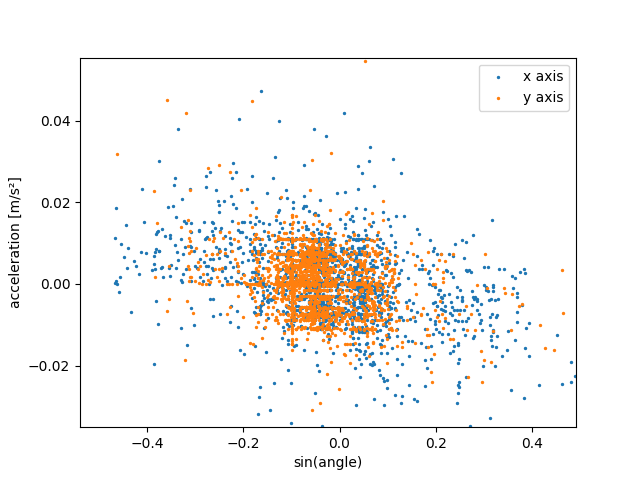

In [92]:
plt.figure()
plt.scatter(data['sin_angle_x'], y_np[:, 0], s=2, label='x axis')
plt.scatter(data['sin_angle_y'], y_np[:, 1], s=2, label='y axis')
plt.xlabel('sin(angle)')
plt.ylabel('acceleration [m/s²]')
plt.legend()

plt.show()

## Physic model

a = 2 * m_b * g * r_arm * r_b² / L / (m_b * r_b² + J_b) * sin(angle) = A * sin(angle)

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * sin(angle)

In [43]:
phy_x = x_np[:, 6:]
reg = LinearRegression(fit_intercept=False).fit(phy_x, y_np)
print('R2 score', reg.score(phy_x, y_np))
print('coef',reg.coef_)
print('coef',reg.intercept_)

R2 score 0.2346143242878845
coef [[-3.35828272e-03  3.95797377e-04]
 [ 6.94432501e-05 -2.54851233e-03]]
coef 0.0


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [44]:
def recurcive_phy_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg.coef_, inputs[i - 1, :] * 7.) + reg.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

### Physical model with friction

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * sin(angle) + c_f * d_x

In [45]:
phy_x_f = x_np[:, 4:]
reg_f = LinearRegression(fit_intercept=False).fit(phy_x_f, y_np)
print('R2 score', reg_f.score(phy_x_f, y_np))
print('coef',reg_f.coef_)
print('coef',reg_f.intercept_)

R2 score 0.24560031908394073
coef [[-1.13375053e-02  1.13492751e-02 -3.40140838e-03  4.54650434e-04]
 [-2.17299272e-03 -1.15260417e-02  6.47455909e-05 -2.60881135e-03]]
coef 0.0


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [46]:
def recurcive_phy_f_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0
    
    inputs[:, 2] = inputs[:, 2] * 7.
    inputs[:, 3] = inputs[:, 3] * 7.

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg_f.coef_, inputs[i - 1, :]) + reg_f.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

### Physical model with position correction

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * c_f * d_x + sin(angle) + c_tr * tr + c_tl * tl * c_br * br + c_bl * bl

In [47]:
reg_corr = LinearRegression(fit_intercept=False).fit(x_np, y_np)
print('R2 score', reg_corr.score(x_np, y_np))
print('coef',reg_corr.coef_)
print('coef',reg_corr.intercept_)

R2 score 0.2706315213076523
coef [[-0.00145407 -0.00031564 -0.00031103 -0.00015644 -0.01163666  0.011896
  -0.00331748  0.00039281]
 [-0.00036426 -0.00065054 -0.00137961 -0.00193624 -0.00190593 -0.01431543
  -0.0001383  -0.00382907]]
coef 0.0


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [48]:
def recurcive_phy_corr_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0
    
    inputs[:, 4] = inputs[:, 6] * 7.
    inputs[:, 5] = inputs[:, 7] * 7.

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg_corr.coef_, inputs[i - 1, :]) + reg_corr.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

# Neural network training
Since the ball behavior isn't linear, multiples NN are created and trained to model the system.

The inputs and targets are converted into pytorch format

In [49]:
nets = [BallNet1Hidden(8, 16, 2), BallNet1Hidden(8, 32, 2), BallNet1Hidden(8, 64, 2), 
        BallNet1Hidden(8, 128, 2), BallNet2Hidden(8, 16, 16, 2), BallNet2Hidden(8, 32, 16, 2),
        BallNet2Hidden(8, 64, 32, 2), BallNet2Hidden(8, 128, 64, 2), BallNet2Hidden(8, 128, 128, 2)]
nets = [BallNet2Hidden(8, 32, 16, 2)]

In [50]:
nets = [train_ball_model(net, x, y, n_epoch=10000) for net in nets]

tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLossBackward>)
tensor(3.3994e-05, grad_fn=<MseLos

## Test

### One step prediction

In [51]:
test_index = 0
test = test_datas[test_index][['tr', 'tl','br', 'bl', 'd_x', 'd_y', 'sin_angle_x', 'sin_angle_y']].to_numpy()
test_scaled = test.copy()

test_scaled[:, 4] = test_scaled[:, 4]
test_scaled[:, 5] = test_scaled[:, 5]
test_scaled[:, 6] = test_scaled[:, 6] * 7.
test_scaled[:, 7] = test_scaled[:, 7] * 7.

y_test = test_datas[test_index][['target_x', 'target_y']].to_numpy()

x_test = Variable(
    torch.from_numpy(
        test_scaled
    ).type(torch.FloatTensor)
)

In [52]:
y_phy = (np.dot(reg.coef_, test_scaled[:, 6:].T) + reg.intercept_).T

y_phy_f = (np.dot(reg_f.coef_, test_scaled[:, 4:].T) + reg.intercept_).T

y_phy_corr = (np.dot(reg_corr.coef_, test_scaled.T) + reg.intercept_).T

y_nn = nets[0].forward(x_test).detach().numpy()

print("Phy model r2:          ", r2_score(y_test, y_phy), "mse :", mean_squared_error(y_test, y_phy))
print("Phy friction model r2: ", r2_score(y_test, y_phy_f), "mse :", mean_squared_error(y_test, y_phy_f))
print("Phy corr model r2:     ", r2_score(y_test, y_phy_corr), "mse :", mean_squared_error(y_test, y_phy_corr))
print("Phy nn model r2:       ", r2_score(y_test, y_nn), "mse :", mean_squared_error(y_test, y_phy))

Phy model r2:           0.2834489875103061 mse : 1.588176959279463e-05
Phy friction model r2:  0.2879715119692505 mse : 1.577996155974715e-05
Phy corr model r2:      0.30603713741944605 mse : 1.5358855284813687e-05
Phy nn model r2:        -0.23017695197928978 mse : 1.588176959279463e-05


### Long term perdiction

In [53]:
start = 500

x_0 = test_datas[test_index]['x'].iloc[start]
y_0 = test_datas[test_index]['y'].iloc[start]
d_x_0 = test_datas[test_index]['d_x'].iloc[start]
d_y_0 = test_datas[test_index]['d_y'].iloc[start]

phy_pos = recurcive_phy_sim(x_0, y_0, d_x_0, d_y_0, test[start:, 6:])

phy_pos_f = recurcive_phy_f_sim(x_0, y_0, d_x_0, d_y_0, test[start:, 4:])

phy_pos_corr = recurcive_phy_corr_sim(x_0, y_0, d_x_0, d_y_0, test[start:, :])

In [54]:
pos_nn = nets[0].recurcive_predict(x_0, y_0, d_x_0, d_y_0, test[start:, :])

<IPython.core.display.Javascript object>


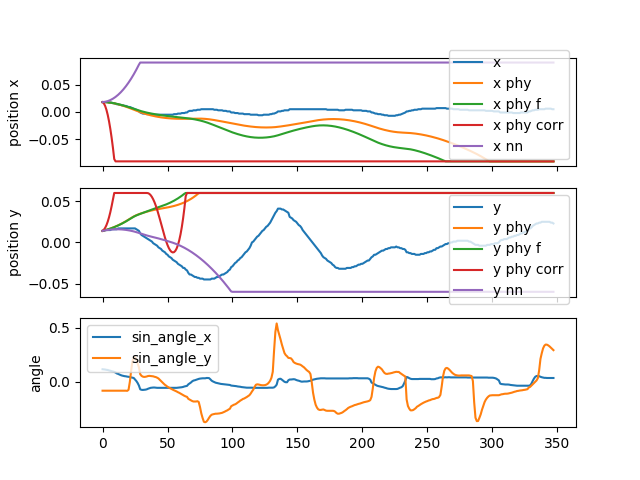

In [55]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(test_datas[test_index]['x'].iloc[start:].to_numpy(), label='x')
axs[0].plot(phy_pos[:, 0], label='x phy')
axs[0].plot(phy_pos_f[:, 0], label='x phy f')
axs[0].plot(phy_pos_corr[:, 0], label='x phy corr')
axs[0].plot(pos_nn[:, 0], label='x nn')
axs[0].set_ylabel('position x')
axs[0].legend()

axs[1].plot(test_datas[test_index]['y'].iloc[start:].to_numpy(), label='y')
axs[1].plot(phy_pos[:, 1], label='y phy')
axs[1].plot(phy_pos_f[:, 1], label='y phy f')
axs[1].plot(phy_pos_corr[:, 1], label='y phy corr')
axs[1].plot(pos_nn[:, 1], label='y nn')
axs[1].set_ylabel('position y')
axs[1].legend()

axs[2].plot(test_datas[test_index]['sin_angle_x'].iloc[start:].to_numpy(), label='sin_angle_x')
axs[2].plot(test_datas[test_index]['sin_angle_y'].iloc[start:].to_numpy(), label='sin_angle_y')
axs[2].set_ylabel('angle')
axs[2].legend()

plt.show()

In [89]:
ball = {
    'phy_i_coef': reg_f.coef_.tolist(),
    's_scaling': 1.,
    'sin_scaling': 7.
}

with open('src/data/ball.json', 'w') as json_file:
    json.dump(ball, json_file)

In [90]:
a = BallSimulation()

{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
